# Settings

# Chat Completions API

Chat Completions API의 기본 요소는 Message 이며, 여기에 Model(gpt-3.5-turbo, gpt-4-turbo-preview 등)을 사용하여 Completion을 수행합니다.

## Test

In [8]:
import openai
import os
from dotenv import load_dotenv # API KEY 정보를 불러옵니다
load_dotenv('./credentials/.env') 
openai.api_key = os.environ.get("OPENAI_API_KEY")

In [ ]:
completion = openai.chat.completions.create(
    model = 'gpt-3.5-turbo',
    messages=[
        {
            'role': 'user',
            'content': '안녕'
        }
    ],
    temperature=0,
    max_tokens=256
)

completion

### 실행결과

### 응답 출력

In [ ]:
print(completion.choices[0].message.content)
    # completion 객체는 OpenAI의 ChatCompletion 클래스의 인스턴스
    # 파이선에서는 클래스 인스턴스의 속성에 . 를 사용해서 접근

# Assistants API

Chat Completions API 는 메시지를 주고 받는데에는 가볍게 잘 동작하지만, 상태를 관리할 수는 없습니다. 
이에 대한 보완책으로 Assistants API 가 탄생하게 되었습니다.

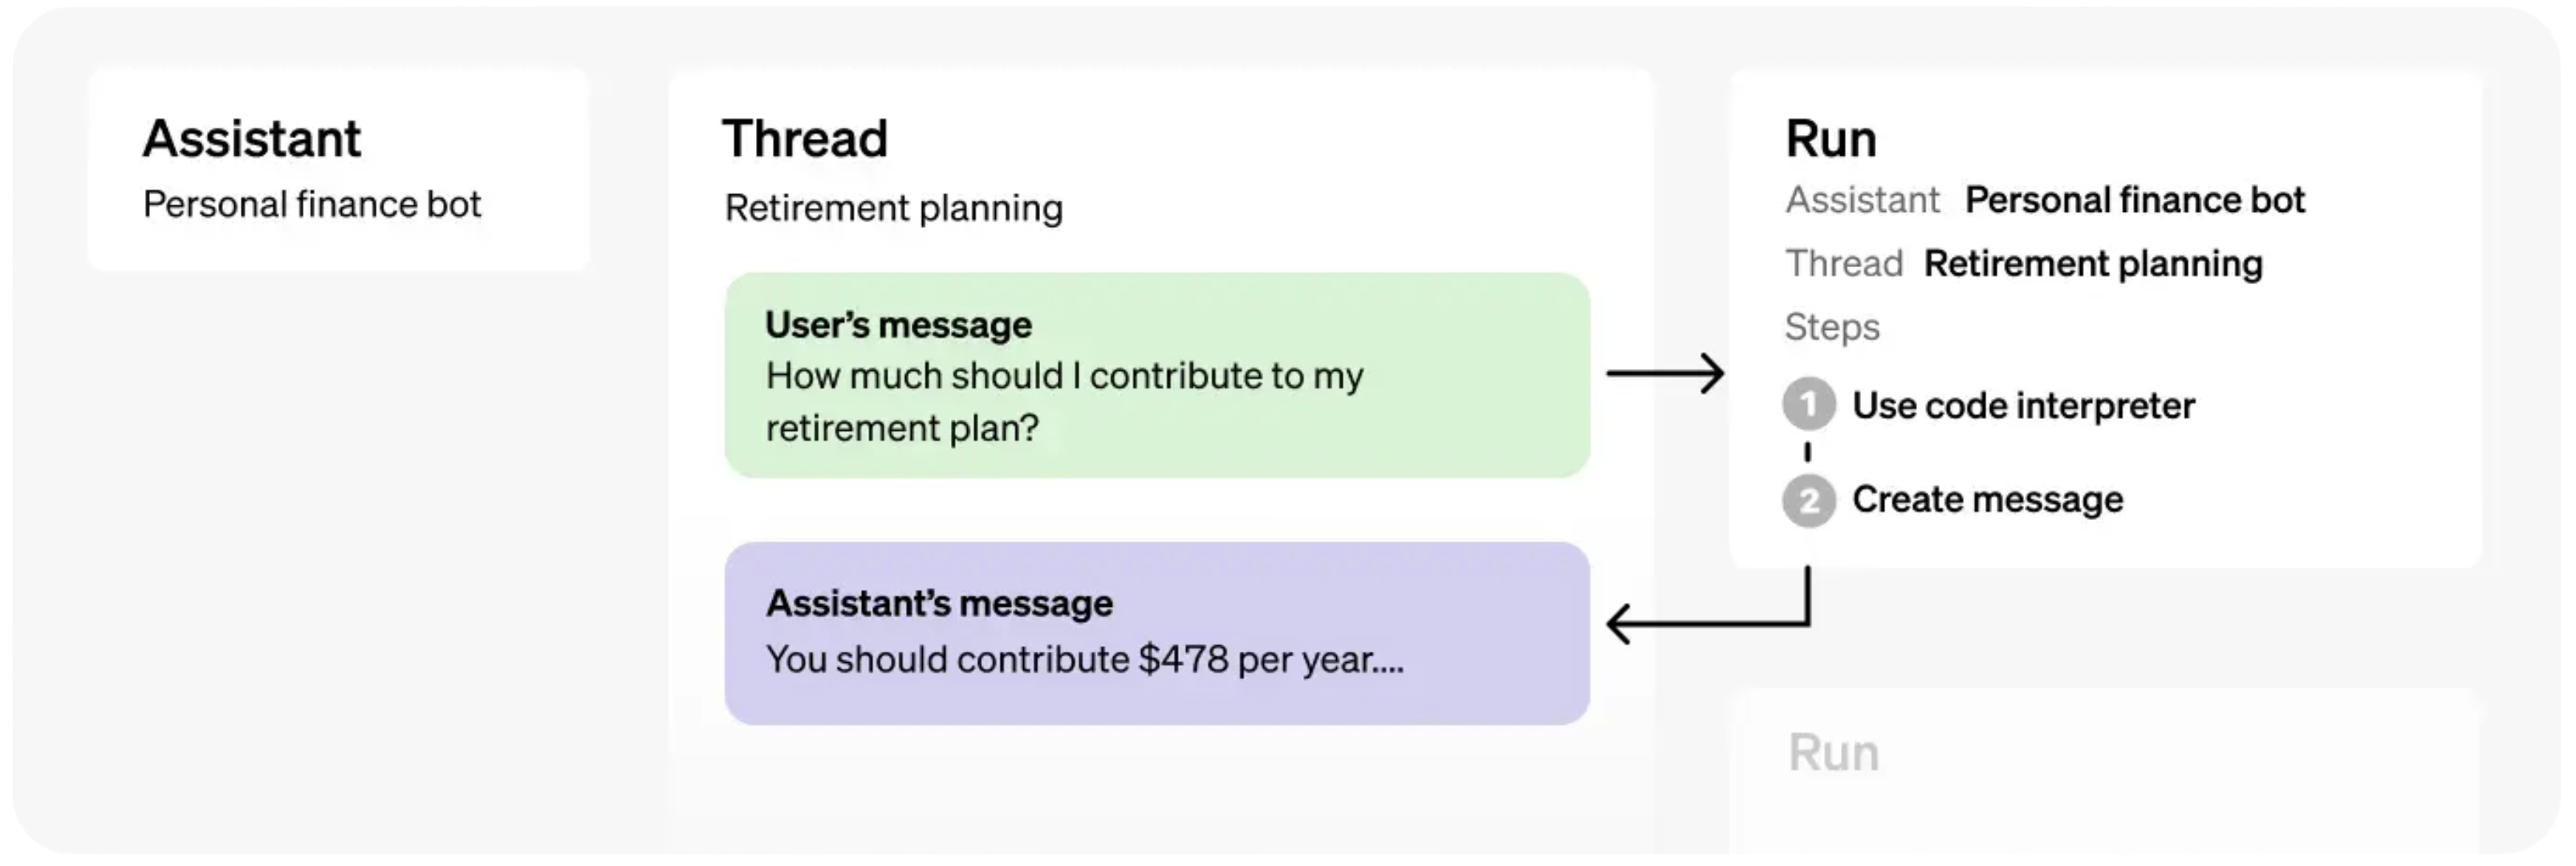

Assistants: 모델(GPT-3.5, GPT-4, etc), instruction(지시문/프롬프트), tools(도구), files(업로드한 파일)를 캡슐화하는 역할입니다.

Threads: 하나의 대화 채널입니다. 

Runs: Assistant + Thread 에서의 실행을 구동합니다. 

### Helper 함수

공식 명칭인가? 아니면 function_calling 인가?

In [17]:
import json

def show_json(obj):
    # obj의 모델을 JSON 형태로 변환한 후 출력합니다.
    display(json.loads(obj.model_dump_json()))

## Test

In [ ]:
from openai import OpenAI

api_key=""

# OpenAI API를 사용하기 위한 클라이언트 객체를 생성합니다.
client = OpenAI(api_key=openai.api_key)

# 수학 과외 선생님 역할을 하는 챗봇을 생성합니다.
assistant = client.beta.assistants.create(
    name="",
    instructions="",
    model="",
)
# 생성된 챗봇의 정보를 JSON 형태로 출력합니다.
show_json(assistant)

In [ ]:
ASSISTANT_ID = assistant.id
print(f"[생성한 Assistants ID]\n{ASSISTANT_ID}")

### Threads 생성

새로운 Thread를 생성하고 그 안에 Message를 추가합니다.
- Threads: Message 풀을 관리하는 집합체. Message 의 상태 관리도 포함입니다.
- Message: 단일 메시지 이며, 각 Message 는 역할(role) 과 컨텐츠(content) 로 구성되어 있습니다.

Thread 는 우리 대화의 상태를 유지해 주는 역할을 합니다.

이전 까지의 대화내용을 기억하고 있기 때문에, 매번 전체 메시지 기록을 다시 보내지 않아도 됩니다.

In [ ]:
# 새로운 스레드를 생성합니다.
thread = client.beta.threads.create()

# 생성된 스레드의 정보를 JSON 형식으로 출력합니다.
show_json(thread)

In [ ]:
# 스레드에 메세지를 추가합니다.
message = client.beta.threads.messages.create(
    thread_id=,
    role="",
    content="",
)
show_json(message)

### Run 생성

사용자에게 응답하도록 Assistant를 활성화하려면 Run을 생성

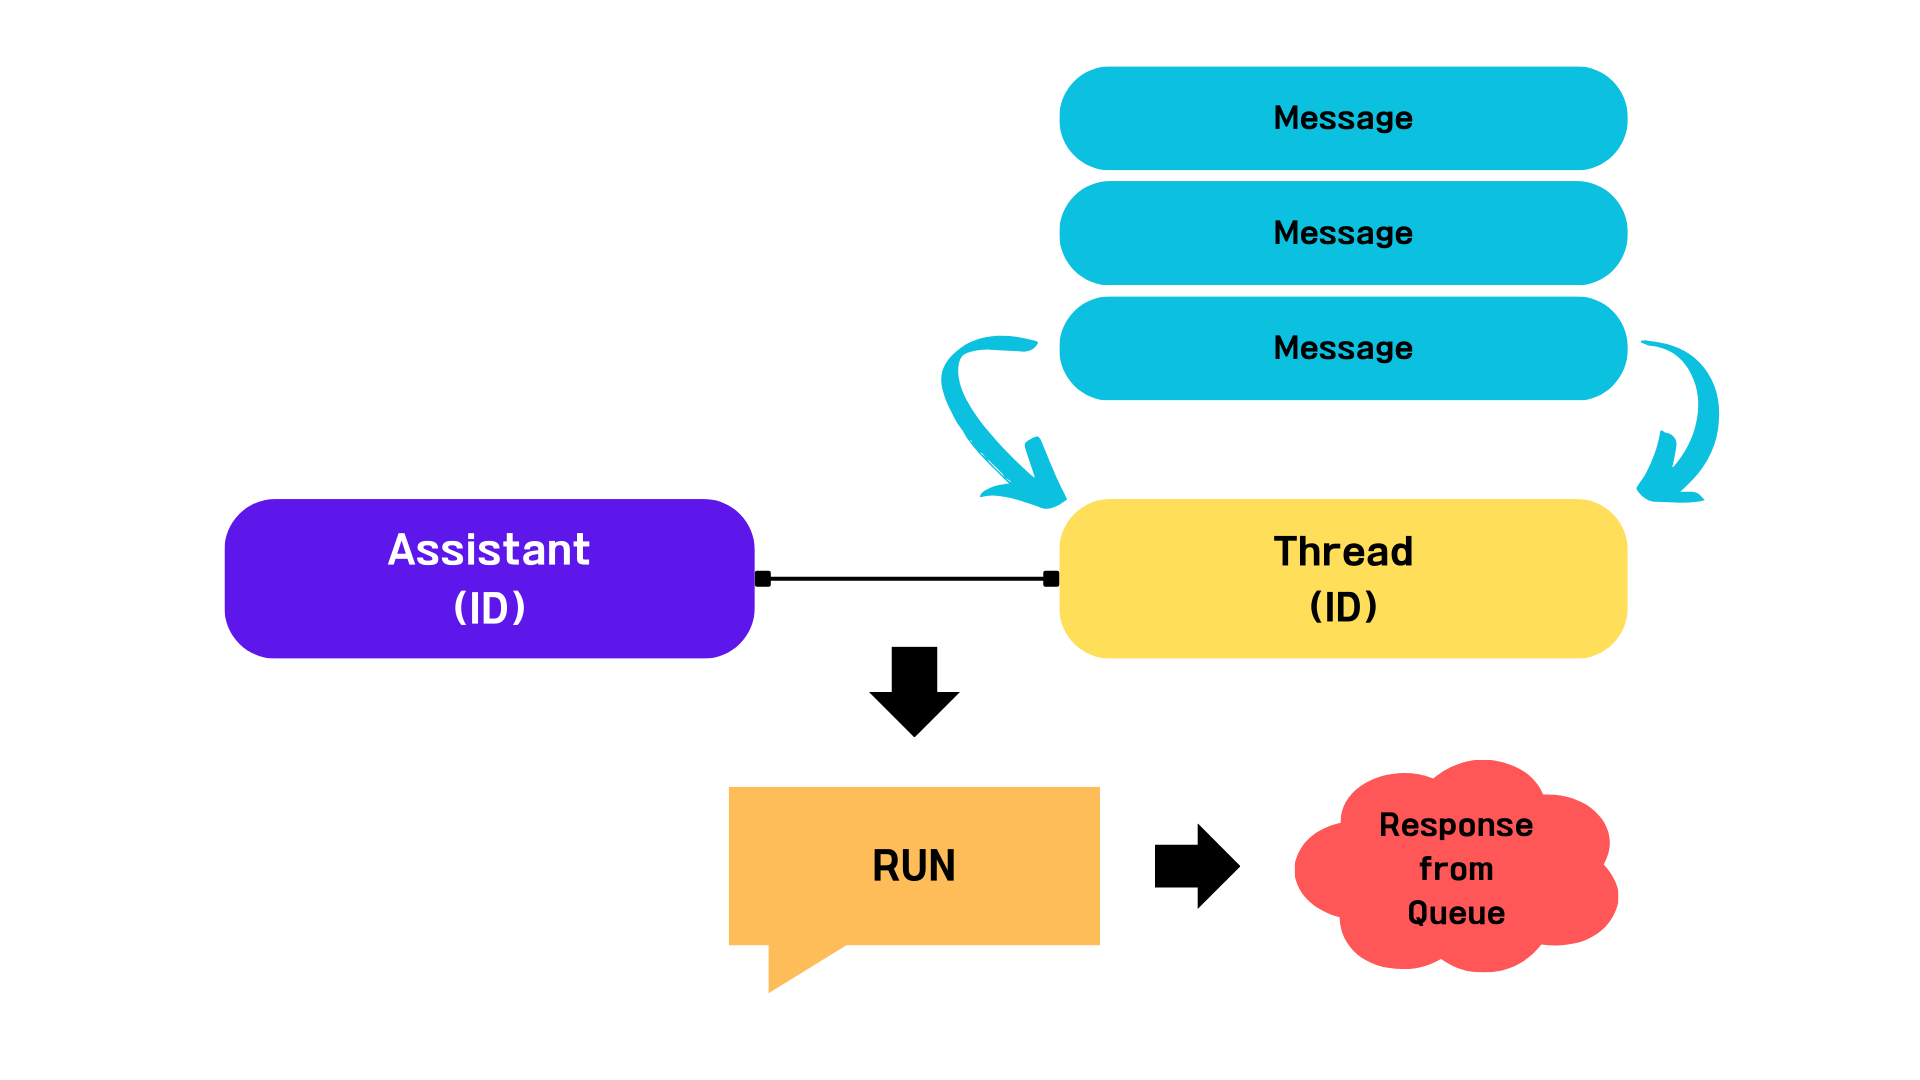

Thread 는 Assistant와 독립적으로 존재 합니다.

Run 이 수행되기 위한 조건에는 Assistant ID 와 Thread ID 가 지정되어야 합니다.

Run은 Assistants API와 Chat Completions API 사이의 주요 차이점입니다. Chat Completions에서는 모델이 단일 메시지로만 응답하지만, Assistants API에서는 Run이 하나 또는 여러 도구를 사용하고, Thread에 여러 메시지를 추가할 수 있습니다.

In [ ]:
# 실행할 Run 을 생성합니다.
# Thread ID 와 Assistant ID 를 지정합니다.
run = client.beta.threads.runs.create(
    thread_id=,  # 생성한 스레드 ID
    assistant_id=,  # 적용할 Assistant ID
)
show_json(run)

Chat Completions API에서 완성을 생성하는 것과 달리, Run을 생성하는 것은 비동기 작업입니다.

이는 Run의 메타데이터와 함께 즉시 반환되며, status 는 queued(대기중) 으로 표기됩니다.

status는 Assistant가 작업을 수행함에 따라(도구 사용 및 메시지 추가와 같은) 업데이트될 것입니다. 상태 값은 아래의 목록을 참고하세요.

- status 목록
    - queued: 아직 실행이 되지 않고 대기중인 상태
    - in_progress: 처리중
    - requires_action: 사용자 입력 대기중
    - cancelling: 작업 취소중
    - cancelled: 작업 취소 완료
    - failed: 실패(오류)
    - completed: 작업 완료
    - expired: 작업 만료

Assistant가 처리를 완료했는지 알기 위해서는 Run을 반복해서 폴링할 수 있습니다.

아래는 Run 의 status(상태) 를 폴링하면서 주기적으로 확인하는 코드입니다.

In [ ]:
import time


# 주어진 실행(run)이 완료될 때까지 대기합니다.
def wait_on_run(run, thread):
    while run.status == "queued" or run.status == "in_progress":
        # run.status 를 업데이트합니다.
        run = client.beta.threads.runs.retrieve(
            thread_id=,
            run_id=,
        )
        # API 요청 사이에 잠깐의 대기 시간을 두어 서버 부하를 줄입니다.
        time.sleep(0.5)
    return run

# run 객체를 대기 상태로 설정하고, 해당 스레드에서 실행을 완료할 때까지 기다립니다.
run = wait_on_run(run, thread)

# status 가 "complete" 인 경우에는 결과를 출력합니다.
show_json(run)

### Message 확인

Run이 완료되었으므로, Assistant에 의해 처리된 결과를 보기 위해 Thread에서 Messages를 확인할 수 있습니다.

In [ ]:
# thread.id를 사용하여 메시지 목록을 가져옵니다.
messages = client.beta.threads.messages.list(thread_id=)

# 결과를 출력합니다.
show_json(messages)

메시지는 역순으로 정렬됩니다.

이는 가장 최근의 결과가 항상 최상단에 있도록 하기 위해서입니다.

In [ ]:
# 스레드에 추가할 메시지 생성합니다.
message = client.beta.threads.messages.create(
    thread_id=,
    role="",
    content="",
)

# 실행을 시작합니다.
run = client.beta.threads.runs.create(
    thread_id=,
    assistant_id=,
)

# 완료될 때까지 대기합니다.
wait_on_run(run, thread)

# 마지막 사용자 메시지 이후에 추가된 모든 메시지를 검색합니다.
messages = client.beta.threads.messages.list(
    thread_id=, order="", after=
)
show_json(messages)

## 정리

1. Asssitant 생성 : Assistant 의 역할 부여.

2. 새로운 Thread 생성 : 해당 Thread 에 Message 추가.

3. Message 생성 : Message 생성시 Thread 의 ID 를 입력하여 Message 추가

4. Run 생성 : Run을 수행할 Assistant 와 실행할 Thread ID 를 지정 후 Run 실행

### 함수화

In [28]:
import time
from openai import OpenAI


# 이전에 설정한 Assistant ID 를 기입합니다.
ASSISTANT_ID = assistant.id

# OpenAI API를 사용하기 위한 클라이언트 객체를 생성합니다.
client = OpenAI(api_key=api_key)


# 사용자 메세지를 제출하는 함수를 미리 작성합니다.
def submit_message(assistant_id, thread, user_message):
    # 사용자 입력 메시지를 스레드에 추가합니다.
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=user_message,
    )
    # 스레드에 메시지가 입력이 완료되었다면, Assistant ID와 Thread ID를 사용하여 실행을 준비합니다.
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant_id,
    )
    return run


# 주어진 실행(run)이 완료될 때까지 대기합니다.
def wait_on_run(run, thread):
    while run.status == "queued" or run.status == "in_progress":
        # run.status 를 업데이트합니다.
        run = client.beta.threads.runs.retrieve(
            thread_id=thread.id,
            run_id=run.id,
        )
        time.sleep(0.5)
    return run


# 스레드에서 메시지 목록을 가져옵니다.
def get_response(thread):
    return client.beta.threads.messages.list(thread_id=thread.id, order="asc")


# 새로운 스레드를 생성하고 메시지를 제출하는 함수를 정의합니다.
def create_thread_and_run(user_input): 
    thread = client.beta.threads.create()
    run = submit_message(ASSISTANT_ID, thread, user_input)
    return thread, run

In [29]:
# 동시에 여러 요청을 처리하기 위해 스레드를 생성합니다.
thread1, run1 = create_thread_and_run("다음 방정식을 풀고 싶습니다. `3x + 11 = 14`. 좀 도와주실 수 있나요?")
thread2, run2 = create_thread_and_run("선형대수에 대해 간략히 설명해 주실 수 있나요?")
thread3, run3 = create_thread_and_run("수학에 정말 소질이 없는 것 같아요. 어떻게 하면 수학을 잘할 수 있을까요?")

비동기로 queued 상태인 Run 을 생성했습니다.

아직 실행이 시작된 것은 아니라는 점을 주의해 주세요.

In [30]:
# 메시지 출력용 함수를 작성합니다.
def print_message(response):
    for res in response:
        print(f"[{res.role.upper()}]\n{res.content[0].text.value}\n")
    print("---" * 20)

모든 실행이 진행되고 나면, 각각을 기다린 후 응답을 받을 수 있습니다.

In [ ]:
# 첫 번째 실행을 위해 대기
run1 = wait_on_run(run1, thread1)
print_message(get_response(thread1))

# 두 번째 실행을 위해 대기
run2 = wait_on_run(run2, thread2)
print_message(get_response(thread2))

# 세 번째 실행을 위해 대기
run3 = wait_on_run(run3, thread3)

# 세 번째 스레드를 마치면 감사 인사를 전하고 종료합니다.
run4 = submit_message(ASSISTANT_ID, thread3, "도와주셔서 감사합니다!")
run4 = wait_on_run(run4, thread3)
print_message(get_response(thread3))

## 템플릿 생성

1. Asssitant 생성 : Assistant 의 역할 부여.

2. 새로운 Thread 생성 : 해당 Thread 에 Message 추가.

3. Message 생성 : Message 생성시 Thread 의 ID 를 입력하여 Message 추가

4. Run 생성 : Run을 수행할 Assistant 와 실행할 Thread ID 를 지정 후 Run 실행

In [ ]:
import openai
from openai import OpenAI

import os
from dotenv import load_dotenv
load_dotenv('./credentials/.env') 
openai.api_key = os.environ.get("OPENAI_API_KEY")
api_key = openai.api_key

import json
import time


client = OpenAI(api_key=api_key)

# Q. 수학 과외 선생님 역할을 하는 챗봇을 생성하는 코드를 작성하세요. (name, instruction, model)



# Q. obj의 모델을 JSON 형태로 변환한 후 출력하는 함수를 작성하세요. (display)



In [ ]:
# Q. 생성한 Aissistant ID를 출력하는 코드를 작성하세요. 


In [5]:
# Q. 실행 상태를 최신 정보로 업데이트(3단계) 및 주어진 실행(4단계)이 완료될 때까지 대기하는 함수를 작성하세요.



# Q. 사용자 메세지를 제출하는 함수를 작성하세요. (메세지 추가(1단계), 실행(2단계))



# Q. 스레드에서 메세지 목록을 가져(조회)오는 함수를 작성하세요. (6단계)



# Q. 메세지를 출력하는 함수를 작성하세요. (7단계)



# Q. 새로운 스레드를 생성하고 메시지를 제출, 출력하는 함수를 정의하세요. (5단계)



In [ ]:
# 새로운 스레드를 생성하고 전체 대화 내용을 출력합니다. (end-point)

def create_new_thread():
    thread = client.beta.threads.create()
    return thread


thread_id = create_new_thread().id 
run = ask(ASSISTANT_ID, thread_id,
          "저는 이 문제를 풀고 싶어요 `1 + 20`. 도와주실 수 있나요?")

In [ ]:
# 전체 대화내용 출력
# print_message(get_response(thread_id).data[:])